Time Series Data Imputation with GANs
=============

By Sohaib Errabii, Mael Lucas

Introduction
------------

This notebook is devoted to the investigation of different GAN based methods for time series imputation.


In [1]:
import random
import numpy as np
from typing import Tuple
import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import DataLoader, TensorDataset
from datasets import UCIHAR
import matplotlib.pyplot as plt
from utils import imputation_rmse

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
np.random.seed(manualSeed)
torch.manual_seed(manualSeed);

Random Seed:  999


Inputs
------

Let’s define some inputs for the run:

In [4]:
# Root directory of datasets
root = "data"

# Rate of the missing data
miss_rate = 0.3

# Number of workers for dataloader
workers = 2

# Hidden size of GRU
hz = 64

# Batch size during training/testing
batch_size = 128

# Number of training epochs for imputation model
num_epochs = 20

# Number of training epochs for the classifier
cls_epochs = 100

# Learning rate for optimizers
lr = 0.005

# Generator MSELoss multiplier
alpha = 100

Data
----

We will use the **UCI-HAR** Dataset <https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones>. 



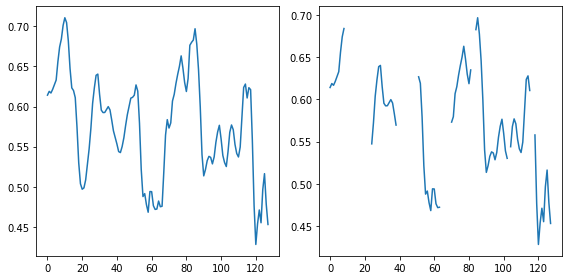

In [3]:
# Create the datasets
ucihar = UCIHAR(root_dir=root, download=True)
ucihar_test = UCIHAR(root_dir=root, train=False)
ucihar_miss = UCIHAR(root_dir=root, miss_rate=miss_rate)

# Create the dataloaders
dataloader = DataLoader(ucihar, batch_size=batch_size, num_workers=workers)
dataloader_test = DataLoader(ucihar_test, batch_size=batch_size, num_workers=workers)
dataloader_miss = DataLoader(ucihar_miss, batch_size=batch_size, num_workers=workers)

# Define UCI-HAR parameters
n_samples, n_timesteps, n_features = ucihar.data.shape
n_classes = len(ucihar.labels)

# Plot some signal before/after amputation
signal_id = random.randrange(n_features)
sample_id = random.randrange(n_samples)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
axes[0].plot(ucihar.data[sample_id, :, signal_id])
axes[1].plot(ucihar_miss.data[sample_id, :, signal_id])
fig.tight_layout()

Model
--------------

We start with a simple GAN model, where the generator and discriminator
are instances of the following GRU-based model.

In [4]:
class GRUPlusFC(nn.Module):
    def __init__(
        self, sequence_length, input_size, 
        hidden_size , output_size, last_only=False):
        super().__init__()
        self.sequence_length = sequence_length
        self.hidden_size = hidden_size
        self.last_only = last_only
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        output, _ = self.gru(x, self._init_hidden(x.size(0)))
        output = self.fc(nn.ReLU(True)(output))
        if self.last_only:
            return output[:, -1]
        else:
            return nn.Sigmoid()(output)
    
    def _init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size)


def generator_loss(
        x: Tensor, x_hat: Tensor,
        mask: Tensor, d_x: Tensor) -> Tuple[Tensor, Tensor]:
    return (nn.MSELoss()(mask * x, mask * x_hat) / torch.mean(mask.float()),
           torch.mean(~mask * torch.log(torch.add(d_x, 1e-8)))
    )

@torch.no_grad()
def evaluate(
    gen_model: nn.Module,
    x_original: Tensor,
    x_miss: Tensor) -> Tuple[Tensor, float]:
    gen_model.eval()
    
    z = torch.rand(x_miss.shape) * 0.01
    mask = ~torch.isnan(x_miss)
    x_noised = mask * torch.nan_to_num(x_miss) + ~mask * z

    xG = gen_model(x_noised)
    
    x_imputed = mask * x_noised + ~mask * xG
    rmse = imputation_rmse(x_original.numpy(), xG.numpy(), mask.numpy())
    
    return x_imputed, rmse

In [5]:
# Generator & Discriminator
netG = GRUPlusFC(n_timesteps, n_features, hz, n_features)
netD = GRUPlusFC(n_timesteps, n_features, hz, n_features)

# Loss functions
criterionG = generator_loss
criterionD = nn.BCELoss()

# Optimizers
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr)
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr)

Training
--------------

In [6]:
# Training Loop

# Lists to keep track of progress
lossesG = []
lossesD = []
rmse_vals = []

for epoch in range(num_epochs):
    netG.train()
    for i, (data, _) in enumerate(dataloader_miss):
        # Sample random noise
        z = torch.rand(data.shape) * 0.01
        
        # Get binary mask from data, mask = 1 if observed
        mask = ~torch.isnan(data)
        
        # Combine random noise with observed data
        data = mask * torch.nan_to_num(data) + ~mask * z
        
        ###################################
        # (1) Update D: minimize BCE(M, D(G(x)))
        ###################################
        netD.zero_grad()
        
        # Generate imputed data with G
        dataG = netG(data)
        
        # Classify imputed data with D
        data_imp = mask * data + ~mask * dataG
        probD = netD(data_imp.detach())
        
        # Compute loss for D
        lossD = criterionD(probD, mask.float())
        # Compute gradients for D
        lossD.backward()
        # Update D
        optimizerD.step()
        
        ###################################
        # (2) Update G: minimize MSE(M * x, M * G(x)) - (1 - M) * log(D(G(x))
        ###################################
        netG.zero_grad()
        
        # Classify imputed data once more since D got updated
        probD = netD(data_imp)
                
        # Compute loss for G
        loss_rec, loss_adv = criterionG(data, dataG, mask, probD)
        lossG = alpha * loss_rec - loss_adv
        # Compute gradients for G
        lossG.backward()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 50 == 0:
            print(
                f"[{epoch}/{num_epochs}][{i}/{len(dataloader)}]\t"
                f"LossD: {lossD.item():04f}\tLossG_rec: {loss_rec.item():04f}"
                f"\tLossG_adv: {-loss_adv.item():04f}"
            )

        # Save Losses for plotting later
        lossesG.append(lossG.item())
        lossesD.append(lossD.item())
        
    # Compute the rmse every 5 epochs
    if (epoch + 1) % 5 == 0:
        x_temp, rmse = evaluate(netG, ucihar.data, ucihar_miss.data)
        rmse_vals.append(rmse)
        print(f"At Epoch {epoch}, Obtained rmse: {rmse}")
        
        # Save new best imputed dataset
        if rmse == min(rmse_vals):
            print(f"Reached rmse: {rmse}")
            print(f"Storing new imputed dataset at epoch {epoch}")
            x_imputed = x_temp
            # ucihar_miss.save_data("results", x_imputed)

#x_imputed, rmse = evaluate(netG, ucihar.data, ucihar_miss.data)
#ucihar_miss.save_data("results", x_imputed)

[0/100][0/58]	LossD: 0.691742	LossG_rec: 0.011154	LossG_adv: 0.198381
[0/100][50/58]	LossD: 0.610060	LossG_rec: 0.005475	LossG_adv: 0.107981
[1/100][0/58]	LossD: 0.611342	LossG_rec: 0.003223	LossG_adv: 0.107000
[1/100][50/58]	LossD: 0.609385	LossG_rec: 0.004678	LossG_adv: 0.107356
[2/100][0/58]	LossD: 0.610256	LossG_rec: 0.003064	LossG_adv: 0.107604
[2/100][50/58]	LossD: 0.596935	LossG_rec: 0.003471	LossG_adv: 0.110283
[3/100][0/58]	LossD: 0.593558	LossG_rec: 0.002422	LossG_adv: 0.114054
[3/100][50/58]	LossD: 0.541562	LossG_rec: 0.002463	LossG_adv: 0.137620
[4/100][0/58]	LossD: 0.536283	LossG_rec: 0.001928	LossG_adv: 0.140070
[4/100][50/58]	LossD: 0.486212	LossG_rec: 0.001898	LossG_adv: 0.173554
At Epoch 4, Obtained rmse: 0.13517517933805917
Reached rmse: 0.13517517933805917
Storing new imputed dataset at epoch 4
[5/100][0/58]	LossD: 0.486417	LossG_rec: 0.001667	LossG_adv: 0.169062
[5/100][50/58]	LossD: 0.462557	LossG_rec: 0.001823	LossG_adv: 0.184552
[6/100][0/58]	LossD: 0.490844	Loss

[52/100][50/58]	LossD: 0.608147	LossG_rec: 0.000072	LossG_adv: 0.107467
[53/100][0/58]	LossD: 0.610045	LossG_rec: 0.000092	LossG_adv: 0.111928
[53/100][50/58]	LossD: 0.608254	LossG_rec: 0.000059	LossG_adv: 0.107322
[54/100][0/58]	LossD: 0.610649	LossG_rec: 0.000071	LossG_adv: 0.106628
[54/100][50/58]	LossD: 0.607610	LossG_rec: 0.000059	LossG_adv: 0.107697
At Epoch 54, Obtained rmse: 0.0654281838261263
[55/100][0/58]	LossD: 0.609623	LossG_rec: 0.000069	LossG_adv: 0.107184
[55/100][50/58]	LossD: 0.609285	LossG_rec: 0.000063	LossG_adv: 0.107690
[56/100][0/58]	LossD: 0.610498	LossG_rec: 0.000067	LossG_adv: 0.107730
[56/100][50/58]	LossD: 0.606560	LossG_rec: 0.000057	LossG_adv: 0.106882
[57/100][0/58]	LossD: 0.609483	LossG_rec: 0.000064	LossG_adv: 0.107117
[57/100][50/58]	LossD: 0.607119	LossG_rec: 0.000060	LossG_adv: 0.107254
[58/100][0/58]	LossD: 0.609371	LossG_rec: 0.000064	LossG_adv: 0.106824
[58/100][50/58]	LossD: 0.606430	LossG_rec: 0.000051	LossG_adv: 0.107086
[59/100][0/58]	LossD: 0

## Results


### Loss versus training iteration

Below is a plot of D & G’s losses versus training iterations.

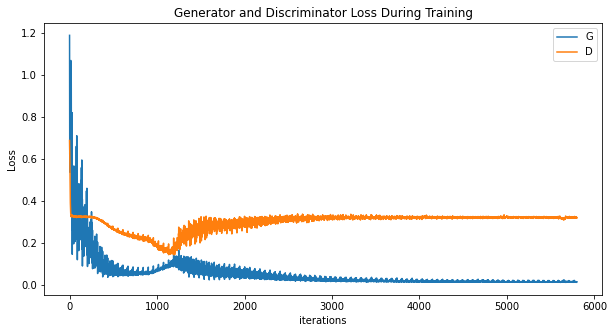

In [8]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(lossesG, label="G")
plt.plot(lossesD, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### RMSE versus Epoch

Below is a plot of the RMSE every $5$ epochs of training

The **rmse** metric by itself is not very useful, but it will be used compare against _improved_ versions of the GAN-based model or other imputation methods (MissForest, MICE, $\dots$).

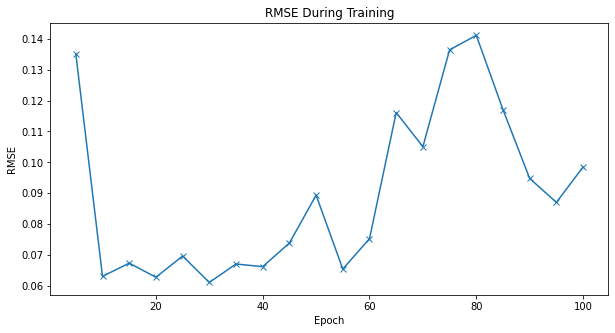

Minimum RMSE of 0.0611 achieved around epoch 30


In [11]:
plt.figure(figsize=(10,5))
plt.title("RMSE During Training")
plt.plot(np.arange(5, num_epochs + 1, 5), rmse_vals, marker='x')
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.savefig(f"results/rmse_mcar_{int(miss_rate * 100)}_{num_epochs}.png")
plt.show()

from operator import itemgetter
argmin_rmse, min_rmse = min(enumerate(rmse_vals), key=itemgetter(1))
print(
    f"Minimum RMSE of {min_rmse:.4f} "
    f"achieved around epoch {(argmin_rmse + 1) * 5}"
)


### Imputation

We now impute the data and save it in `x_imputed`.

In [ ]:
# RMSE performance
x_imputed, rmse = evaluate(netG, ucihar.data, ucihar_miss.data)
print(f"RMSE Performance: {rmse}")

# Plot some signal before/after imputation
signal_id = random.randrange(n_features)
sample_id = random.randrange(n_samples)
plt.plot(ucihar.data[sample_id, :, signal_id], label="real")
plt.plot(x_imputed[sample_id, :, signal_id], label="imputed")
plt.legend()
plt.show()

### Performance Comparison for Classification Task

We compare the test accuracy obtained by training a classifier on the complete
dataset, mean imputation and our GAN-based imputation.

For the classifier, we use the model `GRUPlusFC`.

In [8]:
def train(model, loader, optimizer):
    loss_epoch = 0
    accuracy_epoch = 0

    for i, (x, y) in enumerate(loader):
        optimizer.zero_grad()
        output = model(x)
        loss = nn.CrossEntropyLoss()(output, y)
        
        predicted = output.argmax(1)
        acc = (predicted == y).sum().item() / y.size(0)
        accuracy_epoch += acc
        
        loss.backward()
        optimizer.step()

        loss_epoch += loss.item()
        # if i % 50 == 0:
        #     print(
        #         f"Step [{i}/{len(loader)}]\t Loss: {loss.item()}\t Accuracy: {acc}"
        #     )
    return loss_epoch / len(loader), accuracy_epoch / len(loader)


def test(model, loader):
    model.eval()
    accuracy_epoch = 0
    for i, (x, y) in enumerate(loader):
        # Classify batch with model
        output = model(x)

        # Compute batch accuracy
        predicted = output.argmax(1)
        acc= (predicted == y).sum().item() / y.size(0)
        accuracy_epoch += acc
           
    return accuracy_epoch / len(loader)

#### Training the classifier on the GAN-imputed dataset

First, we train the classifier on the imputed data `x_imputed` (computed above for **rmse**) and save the test accuracy obtained every
$20$ epochs in the list `test_accuracies`.

In [ ]:
# Classifier model
cls = GRUPlusFC(n_timesteps, n_features, hz, n_classes, last_only=True)

# Optimizer
optimizer = torch.optim.Adam(cls.parameters(), lr=lr)

# Create loader for imputed data
dataloader_imp = DataLoader(
    TensorDataset(x_imputed, ucihar.targets),
    batch_size=batch_size, 
    num_workers=workers
)

# Train the classifier on the imputed dataset
test_accuracies = []
for epoch in range(cls_epochs):
    # Train
    loss_epoch, accuracy_epoch = train(cls, dataloader_imp, optimizer)
    
    print(f"Epoch [{epoch}/{cls_epochs}]\t Loss: {loss_epoch}\t Train Accuracy: {accuracy_epoch}")
    
    # Test
    if (epoch + 1) % 20 == 0:
        acc = test(cls, dataloader_test)
        test_accuracies.append(acc)
        print(f"At epoch {epoch}, obtained accuracy: {acc}")

#### Training the classifier on the original dataset 

Next we can train the classifier on the real/observed dataset and save the test accuracies in `test_accuracies_complete`.

In [12]:
# Classifier model
cls = GRUPlusFC(n_timesteps, n_features, hz, n_classes, last_only=True)

# Optimizers
optimizer = torch.optim.Adam(cls.parameters(), lr=lr)

test_accuracies_complete = []

for epoch in range(cls_epochs):
    # Train
    loss_epoch, accuracy_epoch = train(cls, dataloader, optimizer)
    
    print(f"Epoch [{epoch}/{cls_epochs}]\t Loss: {loss_epoch}\t Train Accuracy: {accuracy_epoch}")
    
    # Test
    if (epoch + 1) % 20 == 0:
        acc = test(cls, dataloader_test)
        test_accuracies_complete.append(acc)

Epoch [0/200]	 Loss: 1.788800295056968	 Train Accuracy: 0.2231950431034483
Epoch [1/200]	 Loss: 1.7326531697963845	 Train Accuracy: 0.3096713362068966
Epoch [2/200]	 Loss: 1.6693052855031243	 Train Accuracy: 0.27882543103448276
Epoch [3/200]	 Loss: 1.3837709221346626	 Train Accuracy: 0.3648976293103448
Epoch [4/200]	 Loss: 1.4654730455628757	 Train Accuracy: 0.3403825431034483
Epoch [5/200]	 Loss: 1.3312028687575768	 Train Accuracy: 0.4089439655172414
Epoch [6/200]	 Loss: 1.2940056365111778	 Train Accuracy: 0.4151400862068966
Epoch [7/200]	 Loss: 1.2895116754646958	 Train Accuracy: 0.4040948275862069
Epoch [8/200]	 Loss: 1.3532058113607868	 Train Accuracy: 0.4141009852216749
Epoch [9/200]	 Loss: 1.2706992328166962	 Train Accuracy: 0.4597252155172414
Epoch [10/200]	 Loss: 1.1501707167461002	 Train Accuracy: 0.5386006773399015
Epoch [11/200]	 Loss: 1.0598364184642661	 Train Accuracy: 0.5433151169950738
Epoch [12/200]	 Loss: 1.9741546799396645	 Train Accuracy: 0.2689924568965517
Epoch [13

Epoch [107/200]	 Loss: 0.1539797983212589	 Train Accuracy: 0.9392510775862069
Epoch [108/200]	 Loss: 0.1589687604071765	 Train Accuracy: 0.9366918103448276
Epoch [109/200]	 Loss: 0.19150107994611407	 Train Accuracy: 0.9209321120689655
Epoch [110/200]	 Loss: 0.2743050737852423	 Train Accuracy: 0.8957435344827587
Epoch [111/200]	 Loss: 0.223137229456213	 Train Accuracy: 0.9085398706896551
Epoch [112/200]	 Loss: 0.16016683012150743	 Train Accuracy: 0.9401939655172413
Epoch [113/200]	 Loss: 0.14285820836185253	 Train Accuracy: 0.9424838362068966
Epoch [114/200]	 Loss: 0.14086671427679087	 Train Accuracy: 0.9431573275862069
Epoch [115/200]	 Loss: 0.15479394602830168	 Train Accuracy: 0.9365571120689655
Epoch [116/200]	 Loss: 0.16112508316893645	 Train Accuracy: 0.9373653017241379
Epoch [117/200]	 Loss: 0.16177435456935702	 Train Accuracy: 0.9350754310344828
Epoch [118/200]	 Loss: 0.18405643113936973	 Train Accuracy: 0.9248383620689655
Epoch [119/200]	 Loss: 0.13860564306980513	 Train Accurac

In [10]:
print(max(test_accuracies))

0.8961588541666666


#### Training the classifier on a mean-imputed dataset

Finally, for the sake of comparaison we also train the classifier on the dataset that is imputed using the **mean**
of every time window (sequence of length $128$). The test accuracies obtained every $20$ epochs are saved in `test_accuracies_mean`.

In [13]:
# Mean imputation
with torch.no_grad():
    x_miss = ucihar_miss.data
    x_mean = torch.nanmean(x_miss, dim=1, keepdim=True)
    mask = ~torch.isnan(x_miss)
    x_imputed_mean = mask * torch.nan_to_num(x_miss) + ~mask * x_mean

# Dataloader for mean imputed UCI-HAR
dataloader_mean = DataLoader(
    TensorDataset(x_imputed_mean, ucihar.targets),
    batch_size=batch_size, 
    num_workers=workers
)

# Classifier model
cls = GRUPlusFC(n_timesteps, n_features, hz, n_classes, last_only=True)

# Optimizers
optimizer = torch.optim.Adam(cls.parameters(), lr=lr)

test_accuracies_mean = []

for epoch in range(cls_epochs):
    # Train
    loss_epoch, accuracy_epoch = train(cls, dataloader_mean, optimizer)
    
    print(f"Epoch [{epoch}/{cls_epochs}]\t Loss: {loss_epoch}\t Train Accuracy: {accuracy_epoch}")
    
    # Test
    if (epoch + 1) % 20 == 0:
        acc = test(cls, dataloader_test)
        test_accuracies_mean.append(acc)

Epoch [0/200]	 Loss: 1.5567129418767731	 Train Accuracy: 0.3236799568965517
Epoch [1/200]	 Loss: 1.4113483778361617	 Train Accuracy: 0.3714978448275862
Epoch [2/200]	 Loss: 1.4232910727632457	 Train Accuracy: 0.3616648706896552
Epoch [3/200]	 Loss: 1.7277540276790488	 Train Accuracy: 0.2599676724137931
Epoch [4/200]	 Loss: 1.3938415625999714	 Train Accuracy: 0.3806573275862069
Epoch [5/200]	 Loss: 1.3212428051849892	 Train Accuracy: 0.4146012931034483
Epoch [6/200]	 Loss: 1.2706208064638336	 Train Accuracy: 0.465459513546798
Epoch [7/200]	 Loss: 1.2193594831844856	 Train Accuracy: 0.4503733066502463
Epoch [8/200]	 Loss: 1.1645777800987507	 Train Accuracy: 0.45306727216748766
Epoch [9/200]	 Loss: 1.0420795843519013	 Train Accuracy: 0.539678263546798
Epoch [10/200]	 Loss: 1.048734931082561	 Train Accuracy: 0.5605180110837439
Epoch [11/200]	 Loss: 0.9099151389352207	 Train Accuracy: 0.6177070504926109
Epoch [12/200]	 Loss: 0.6949027113873383	 Train Accuracy: 0.6982951046798029
Epoch [13/2

Epoch [107/200]	 Loss: 0.1508205408142109	 Train Accuracy: 0.9412715517241379
Epoch [108/200]	 Loss: 0.1401038573039214	 Train Accuracy: 0.9470635775862069
Epoch [109/200]	 Loss: 0.12832579272397762	 Train Accuracy: 0.9494881465517241
Epoch [110/200]	 Loss: 0.12590507111674704	 Train Accuracy: 0.9517780172413793
Epoch [111/200]	 Loss: 0.12887870949283564	 Train Accuracy: 0.9521821120689655
Epoch [112/200]	 Loss: 0.12185447992443846	 Train Accuracy: 0.9543372844827587
Epoch [113/200]	 Loss: 0.12253030673334785	 Train Accuracy: 0.9529903017241379
Epoch [114/200]	 Loss: 0.12162440127413619	 Train Accuracy: 0.9558189655172413
Epoch [115/200]	 Loss: 0.12109401328629686	 Train Accuracy: 0.9523168103448276
Epoch [116/200]	 Loss: 0.12180004958733254	 Train Accuracy: 0.9502963362068966
Epoch [117/200]	 Loss: 0.11981684095635187	 Train Accuracy: 0.9543372844827587
Epoch [118/200]	 Loss: 0.12380389382338637	 Train Accuracy: 0.9490840517241379
Epoch [119/200]	 Loss: 0.14889915594991682	 Train Accu

In [16]:
rmse = imputation_rmse(ucihar.data.numpy(), x_imputed_mean.numpy(), mask.numpy())
   
print(f"RMSE on mean imputed dataset: {rmse:.4f}")

RMSE on mean imputed dataset: 0.0519


#### Comparaison of test accuracy

Maximum accuracy on mean imputed dataset: 0.8955


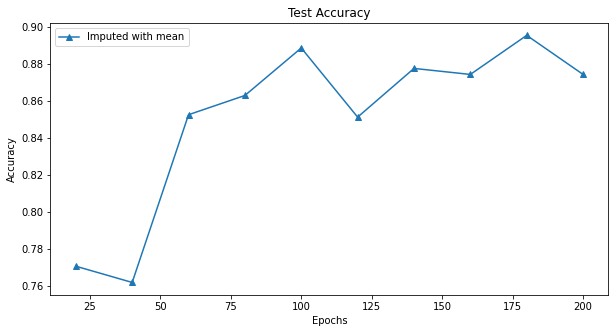

In [14]:
# Maximum accuracy achieved
#print(f"Maximum accuracy on original dataset: {max(test_accuracies_complete):.4f}")
#print(f"Maximum accuracy on GAN-imputed dataset: {max(test_accuracies):.4f}")
print(f"Maximum accuracy on mean imputed dataset: {max(test_accuracies_mean):.4f}")

# Plot test accuracy
plt.figure(figsize=(10,5))
plt.title("Test Accuracy")
#plt.plot(np.arange(20, cls_epochs + 1, 20), test_accuracies, marker='x', label='Imputed with GAN')
plt.plot(np.arange(20, cls_epochs + 1, 20), test_accuracies_mean, marker='^', label='Imputed with mean')
#plt.plot(np.arange(20, cls_epochs + 1, 20), test_accuracies_complete, marker='o', label='Original')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(f"results/accuracy_mcar_{int(miss_rate * 100)}.png")
plt.show()

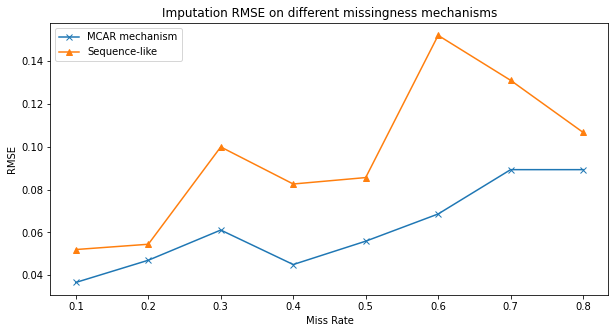

In [20]:
# Plot test accuracy
plt.figure(figsize=(10,5))
plt.title("Imputation RMSE on different missingness mechanisms")
miss_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
#gan_acc = [0.9163, 0.908203125, 0.89615, 0.9199, 0.9053, 0.7311, 0.8590, 0.7949]
#mean_acc = [0.9170, 0.9004, 0.8955, 0.8919, 0.8087, 0.7106, 0.7144, 0.6794]
#plt.axhline(y=0.91014, color='r', linestyle='--', label='Original')
rmse_mcar = [0.0366354, 0.0470, 0.0611, 0.045, 0.0559, 0.0686, 0.0893, 0.0893]
rmse_seq = [0.052, 0.05447, 0.0999, 0.0826, 0.0856, 0.1520, 0.131, 0.1067]
plt.plot(miss_rates, rmse_mcar, marker='x', label='MCAR mechanism')
plt.plot(miss_rates, rmse_seq, marker='^', label='Sequence-like')
plt.xlabel("Miss Rate")
plt.ylabel("RMSE")
plt.legend()
plt.savefig(f"results/sequence-vs-mcar.png")
plt.show()

